In [2]:
%load_ext autoreload
%autoreload 2

In [56]:
import sys
sys.path.insert(0, '/home/brysongray/fibermetric/')
sys.path.insert(0, '/home/brysongray/periodic-kmeans/')
from fibermetric import histology, sta_validate
from measures.measures import euclidean1D, angle1D
from periodic_kmeans.periodic_kmeans import periodic_kmeans, PeriodicKMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
import cProfile
import tqdm
import time

In [ ]:
width = 1
# derivative_sigmas = np.linspace(start=0.25, stop=5.0, num=10)
# tensor_sigmas = np.linspace(start=5.0, stop=17.0, num=10)
width = 2
periods = [6,10,14]
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=10.0, num=10)
mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists

anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240)]
AI_ratio = [a[1]/a[0] for a in anisotropy]
print(derivative_sigmas)
print(tensor_sigmas)
print(AI_ratio)
# d = 9
# t = 2
# a = 0
# p = 0
# # g = 7
# err_type = 'piecewise'
# error_by_theta = []
# for g in range(len(grid_thetas)):
#     if g == 6:
#         display=True
#     else:
#         display=False
#     error_by_theta.append(sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=periods[p], noise=1e-9, width=width, phantom='grid', grid_thetas=grid_thetas[g], err_type=err_type, display=display)) # , grid_thetas=(-np.pi/6,np.pi/3)
# avg_error = np.mean(error_by_theta)
# print(avg_error)
# with cProfile.Profile() as pr:
#     error = sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=periods[p], noise=1e-9, width=width, phantom='grid', grid_thetas=grid_thetas[g], err_type=err_type, display=True) # , grid_thetas=(-np.pi/6,np.pi/3)
#     print(f'{err_type} error: {error}')
    # pr.print_stats()

In [ ]:
d = 1
t = 9
a = 3
p = 1
g = 10
err_type = 'piecewise'
error = sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=periods[p], noise=1e-9, width=width, phantom='grid', grid_thetas=grid_thetas[g], err_type=err_type, display=display) # , grid_thetas=(-np.pi/6,np.pi/3)
print(error)

Elapsed time: 0.15074586868286133 s


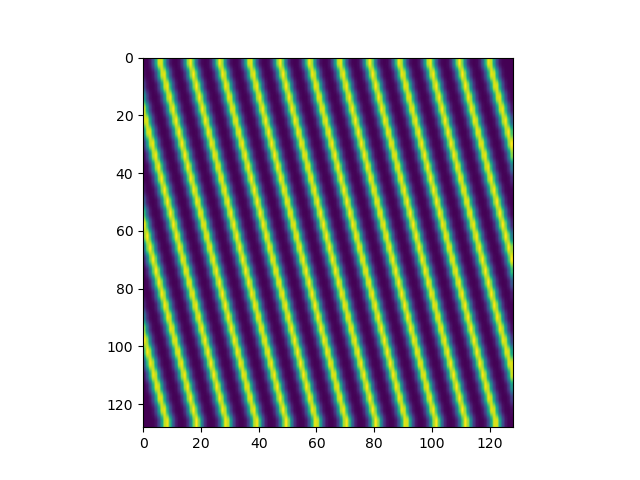

In [57]:
theta = 15 * np.pi/180
t1 = time.time()
for i in range(100):
    I, extent = sta_validate.parallel_lines_2d_v01(thetas=[theta], period=10, noise=1e-9, nI=(32,128))
t2 = time.time()
fig, ax = plt.subplots()
ax.imshow(I, extent=extent)
print(f'Elapsed time: {t2-t1} s')

In [60]:
t1 = time.time()
for i in range(100):
    I, extent, labels = sta_validate.parallel_lines_2d(thetas=[theta], period=10, noise=1e-9, nI=(32,128))
t2 = time.time()
# fig, ax = plt.subplots()
# ax.imshow(I, extent=extent)
print(f'Elapsed time: {t2-t1} s')

Elapsed time: 0.1737062931060791 s


## Test different mixture modelling methods

In [ ]:
width = 2
periods = 15
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=8.0, num=10)
mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists

anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240)]
# errors = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=anisotropy, periods=periods, widths=width, noises=0.0, phantom='grid', grid_thetas=grid_thetas, err_type='piecewise')


In [ ]:
# np.save('grid_errors1.npy', errors, allow_pickle=True)

In [ ]:
from scipy.stats import vonmises
from sklearn.cluster import KMeans
import time

mu = np.random.rand(2)*np.pi
mu.sort()
kmeans_diff = []
mle_diff = []
periodic_kmeans_diff = []
kmeans_time = []
mle_time = []
periodic_kmeans_time = []
for i in tqdm.tqdm(range(100)):
    vm1 = vonmises.rvs(6.0, loc=mu[0], size=100)
    vm2 = vonmises.rvs(6.0, loc=mu[1], size=100)
    vm = np.concatenate((vm1,vm2))
    vm = np.where(vm < 0, vm + np.pi, vm)
    time1 = time.time()
    kmeans = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(vm.reshape(-1,1))
    time2 = time.time()
    mu_kmeans = kmeans.cluster_centers_.reshape(-1)
    mu_kmeans.sort()
    time3 = time.time()
    mu_mle, kappa, pi = histology.vm_maximum_likelihood(vm, verbose=False)
    time4 = time.time()
    mu_mle.sort()
    time5 = time.time()
    periodic_kmeans = PeriodicKMeans(vm.reshape(-1,1), period=np.pi, no_of_clusters=2)
    clust_data, wccs_circ, centers = periodic_kmeans.clustering()
    time6 = time.time()
    mu_periodic_kmeans = np.array(centers).squeeze()
    mu_periodic_kmeans.sort()
    if i==0:
        plt.figure()
        plt.hist(vm, bins='auto', density=True)
        plt.plot([mu[0]]*100, np.linspace(0,0.4,num=100), label='mu1')
        plt.plot([mu[1]]*100, np.linspace(0,0.4,num=100), label='mu2')
        plt.plot([mu_kmeans[0]]*100, np.linspace(0,0.4,num=100), label='kmeans 1')
        plt.plot([mu_kmeans[1]]*100, np.linspace(0,0.4,num=100), label='kmeans 2')
        plt.plot([mu_periodic_kmeans[0]]*100, np.linspace(0,0.4,num=100), label='periodic kmeans 1')
        plt.plot([mu_periodic_kmeans[1]]*100, np.linspace(0,0.4,num=100), label='periodic kmeans 2')
        plt.plot([mu_mle[0]]*100, np.linspace(0,0.4,num=100), label='mle 1')
        plt.plot([mu_mle[1]]*100, np.linspace(0,0.4,num=100), label='mle 2')
        plt.legend()
        plt.show()
    kmeans_diff.append([np.min((np.abs(mu_kmeans[0]-mu[0]), np.pi-np.abs(mu_kmeans[0]-mu[0]))), np.min((np.abs(mu_kmeans[1]-mu[1]), np.pi-np.abs(mu_kmeans[1]-mu[1])))])
    mle_diff.append([np.min((np.abs(mu_mle[0]-mu[0]), np.pi-np.abs(mu_mle[0]-mu[0]))), np.min((np.abs(mu_mle[1]-mu[1]), np.pi-np.abs(mu_mle[1]-mu[1])))])
    periodic_kmeans_diff.append([np.min((np.abs(mu_periodic_kmeans[0]-mu[0]), np.pi-np.abs(mu_periodic_kmeans[0]-mu[0]))), np.min((np.abs(mu_periodic_kmeans[1]-mu[1]), np.pi-np.abs(mu_periodic_kmeans[1]-mu[1])))])
    kmeans_time.append(time2-time1)
    mle_time.append(time4-time3)
    periodic_kmeans_time.append(time6-time5)
kmeans_diff = np.array(kmeans_diff)
mle_diff = np.array(mle_diff)
periodic_kmeans_diff = np.array(periodic_kmeans_diff)

In [ ]:
print(f'kmeans mu1 difference: {np.mean(kmeans_diff[0])}\n kmeans mu2 difference: {np.mean(kmeans_diff[1])}')
print(f'mle mu1 difference: {np.mean(mle_diff[0])}\n mle mu2 difference: {np.mean(mle_diff[1])}')
print(f'periodic_kmeans mu1 difference: {np.mean(periodic_kmeans_diff[0])}\n periodic_kmeans mu2 difference: {np.mean(periodic_kmeans_diff[1])}')
print(f'kmeans time: {np.mean(kmeans_time)}')
print(f'mle time: {np.mean(mle_time)}')
print(f'periodic_kmeans time: {np.mean(periodic_kmeans_time)}')

## Show heatmaps of error for derivative sigmas and tensor sigmas for several anisotropies

In [ ]:
# column_labels = ['derivative_sigma', 'tensor_sigma', 'nI', 'period', 'width', 'noise', 'phantom',
#  'error type', 'grid thetas', 'tile size', 'dimensions', 'error']

# periods = [15,10,5]
# # load errors
# errors_df1 = np.load('/home/brysongray/fibermetric/grid_errors1.npy', allow_pickle=True)
# # make erros a pandas dataframe
# errors_df1 = pd.DataFrame(errors_df1, columns=column_labels)

# errors_df2 = np.load('/home/brysongray/fibermetric/grid_errors2.npy', allow_pickle=True)
# # make erros a pandas dataframe
# errors_df2 = pd.DataFrame(errors_df2, columns=column_labels)

# errors_df3 = np.load('/home/brysongray/fibermetric/grid_errors3.npy', allow_pickle=True)
# # make erros a pandas dataframe
# errors_df3 = pd.DataFrame(errors_df3, columns=column_labels)
# errors_df = [errors_df1, errors_df2, errors_df3]

In [ ]:
# i=1
# derivative_sigmas = errors_df[i]['derivative_sigma'].unique()
# tensor_sigmas = errors_df[i]['tensor_sigma'].unique()
# anisotropy = errors_df[i]['nI'].unique()
# grid_thetas = errors_df[i]['grid thetas'].unique()
# print(derivative_sigmas)
# print(tensor_sigmas)

In [ ]:
column_labels = ['derivative_sigma', 'tensor_sigma', 'nI', 'period', 'width', 'noise', 'phantom',
  'error type', 'grid thetas', 'tile size', 'dimensions', 'error']
errors_df = np.load('/home/brysongray/fibermetric/fibermetric/grid_errors.npy', allow_pickle=True)
errors_df = pd.DataFrame(errors_df, columns=column_labels)

In [ ]:
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
anisotropy = errors_df['nI'].unique()
grid_thetas = errors_df['grid thetas'].unique()
periods = errors_df['period'].unique()
print(derivative_sigmas)
print(tensor_sigmas)

In [ ]:
grid_thetas_np = np.stack(grid_thetas)
delta_thetas = np.abs(grid_thetas_np[:,0] - grid_thetas_np[:,1])
print(delta_thetas)

In [ ]:
# get the number of unique values for each parameter
n_derivative_sigmas = len(derivative_sigmas)
n_tensor_sigmas = len(tensor_sigmas)
n_anisotropy = len(anisotropy)
n_thetas = len(grid_thetas)
n_periods = len(periods)

# average the error for each set of grid thetas
# errors = np.zeros((n_periods, n_derivative_sigmas, n_tensor_sigmas, n_anisotropy))
errors = errors_df['error'].values.reshape(-1,n_thetas).astype(float)
errors_by_delta = np.stack([np.mean(errors[:,i::4], 1) for i in range(4)], axis=1)
errors = np.mean(errors, axis=1)
errors = errors.reshape((n_derivative_sigmas, n_tensor_sigmas, n_anisotropy, n_periods))
errors_by_delta = errors_by_delta.reshape((n_derivative_sigmas, n_tensor_sigmas, n_anisotropy, n_periods, 4))
print(f'errors shape: {errors.shape}')
print(f'errors_by_delta shape: {errors_by_delta.shape}')

In [ ]:
# Display 3 sets of error heatmaps, one set for each period, each set with a heatmap for each anisotropy.
# Each heatmap shows the average errors by derivative sigma and tensor sigma.

# plot the error for each anisotropy
rows = 2
cols = 4
for p in range(n_periods):
    fig, axs = plt.subplots(rows,cols, figsize=(8,4), sharex=True, sharey=True)
    fig.suptitle(f'period: {periods[p]}')
    for i in range(n_anisotropy):
        error = errors[...,i,p]
        axs[i//cols,i%cols].imshow(error, vmin=0, vmax=40)
        axs[i//cols,i%cols].set_title(f'anisotropy = {anisotropy[i]}')
        # set x tick labels
        xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
        yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
        axs[i//cols, i%cols].set_xticklabels(xticklabels, rotation=45)
        axs[i//cols, i%cols].set_yticklabels(yticklabels)
        axs[i//cols,i%cols].set_xlabel('tensor sigma')
        axs[i//cols,i%cols].set_ylabel('derivative sigma')
    # add colorbar to the right
    cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')


## Show error verus anisotropy for the best sigmas 

In [ ]:
# find the best sigmas
print(f'errors shape: {errors.shape}')
# the best index will have shape: len(anisotropy) x len(periods) x 2
# the best errors will have shape
best_idx = np.zeros((len(anisotropy), len(periods), 2))
best_errors = np.zeros((len(anisotropy), len(periods)))
for p in range(errors.shape[-1]):
    for i in range(errors.shape[-2]):
        best_idx[i,p] = np.unravel_index(np.argmin(errors[...,i,p]), errors.shape[:-2])
        best_errors[i,p] = np.min(errors[...,i,p])
print(f'best index: {best_idx}\nbest error: {best_errors}')

In [ ]:
plt.close('all')

In [ ]:
# show best errors for each period and each anisotropy
AI_ratio = [a[1]/a[0] for a in anisotropy]
for p in range(n_periods):
    plt.figure()
    plt.plot(AI_ratio, best_errors[:,p], marker='o')
    plt.title(f'period = {periods[p]}')
    plt.xlabel('anisotropy ratio')
    plt.ylabel('best error (degrees)')


In [ ]:
# show the average error versus the anisotropy ratio for each period
for p in range(n_periods):
    plt.figure()
    plt.plot(AI_ratio, np.mean(errors[...,p], axis=(0,1)), marker='o')
    plt.title(f'period = {periods[p]}')
    plt.xlabel('anisotropy ratio')
    plt.ylabel('mean error (degrees)')

In [ ]:
# show the median error versus the anisotropy ratio for each period
for p in range(n_periods):
    plt.figure()
    plt.plot(AI_ratio, np.median(errors[...,p], axis=(0,1)), marker='o')
    plt.title(f'period = {periods[p]}')
    plt.xlabel('anisotropy ratio')
    plt.ylabel('median error (degrees)')

## Show optimal sigmas verus anisotropy for several periods

In [ ]:
# err_by_period = []
# for i in range(3):
#     # get the number of unique values for each parameter
#     derivative_sigmas = errors_df[i]['derivative_sigma'].unique()
#     tensor_sigmas = errors_df[i]['tensor_sigma'].unique()
#     anisotropy = errors_df[i]['nI'].unique()
#     grid_thetas = errors_df[i]['grid thetas'].unique()
#     n_derivative_sigmas = len(derivative_sigmas)
#     n_tensor_sigmas = len(tensor_sigmas)
#     n_anisotropy = len(anisotropy)
#     n_thetas = len(grid_thetas)
#     # average the error for each set of grid thetas
#     errors = errors_df[i]['error'].values.reshape(-1,n_thetas).astype(float)
#     errors = np.mean(errors, axis=1)
#     errors = errors.reshape((n_derivative_sigmas, n_tensor_sigmas, n_anisotropy))
#     err_by_period.append(errors)

In [ ]:
# best_idx = np.zeros((3, len(anisotropy), 2))
# best_errors = np.zeros((3, len(anisotropy)))
# for p in range(len(periods)):
#     for i in range(errors.shape[-1]):
#         best_idx[p,i] = np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1])
#         best_errors[p,i] = np.min(errors[...,i])

In [ ]:
sigma1 = derivative_sigmas[best_idx[...,0].astype(int)]
sigma2 = tensor_sigmas[best_idx[...,1].astype(int)]
print(sigma1)
print(sigma2)

In [ ]:
fig, axs = plt.subplots(2, sharex=True)
for i in range(len(periods)):
    axs[0].plot(AI_ratio, sigma1[:,i], marker='o', label=f'{periods[i]}')
    axs[1].plot(AI_ratio, sigma2[:,i], marker='o')
axs[0].set_ylabel('best derivative sigma')
axs[0].set_xlabel('anisotropy ratio')
axs[1].set_ylabel('best tensor sigma')
axs[1].set_xlabel('anisotropy ratio')
axs[0].legend(loc='lower right')
plt.show()

In [ ]:
best_errors = np.zeros((len(anisotropy), len(periods), 4))
for a in range(len(anisotropy)):
    for p in range(len(periods)):
        best_errors[a,p] = errors_by_delta[best_idx[a,p,0].astype(int), best_idx[a,p,1].astype(int), a, p]
print(best_errors.shape)

In [ ]:
# Show average error versus delta angle at each anisotropy
x_labels = np.unique(np.round(delta_thetas, decimals=3))
avg_errors = np.mean(errors_by_delta, axis=(0,1))
fig, axs = plt.subplots(2,4, sharex=True, sharey=True)
for i in range(len(anisotropy)):
    for j in range(len(periods)):
        axs[i//4,i%4].plot(x_labels, avg_errors[i,j], marker='o', label=f'{periods[j]}')
        # axs[i//4,i%4].plot(x_labels, best_errors[i,j], marker='o', label=f'{periods[j]}')
    axs[i//4, i%4].set_title(f'anisotropy: {anisotropy[i]}')
    axs[i//4, i%4].set_xlabel('delta angle')
    axs[i//4, i%4].set_ylabel('average error')
    axs[i//4, i%4].legend(loc='lower right')



In [ ]:
# Show average error versus delta angle at each anisotropy
x_labels = np.unique(np.round(delta_thetas, decimals=3))
# avg_errors = np.mean(errors_by_delta, axis=(0,1))
fig, axs = plt.subplots(2,4, sharex=True, sharey=True)
for i in range(len(anisotropy)):
    for j in range(len(periods)):
        # axs[i//4,i%4].plot(x_labels, avg_errors[i,j], marker='o', label=f'{periods[j]}')
        axs[i//4,i%4].plot(x_labels, best_errors[i,j], marker='o', label=f'{periods[j]}')
    axs[i//4, i%4].set_title(f'anisotropy: {anisotropy[i]}')
    axs[i//4, i%4].set_xlabel('delta angle')
    axs[i//4, i%4].set_ylabel('best error')
    axs[i//4, i%4].legend(loc='lower right')

In [ ]:
AI_ratio